In [156]:
import numpy as np
import pandas as pd
import h5py
from scipy.optimize import curve_fit
import datetime as dt
import warnings

from scipy.special import erfc
warnings.filterwarnings("ignore")

In [157]:
import matplotlib.pyplot as plt 
plt.style.use('../../style.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [158]:
import sys
sys.path.insert(0, '../../../purity-monitor/')
sys.path.insert(0, '../../WaveformAnalysis/')
import Dataset as Dataset
import StandMonitor as Monitor
import PlotFunctions as Plt
import importlib
importlib.reload(Dataset)
importlib.reload(Monitor)
importlib.reload(Plt)

<module 'PlotFunctions' from '../../WaveformAnalysis\\PlotFunctions.py'>

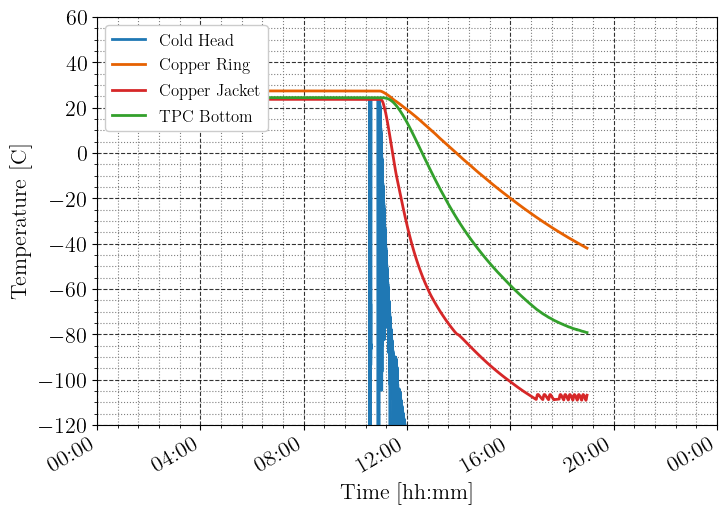

In [376]:
Sensors = []
Files = ['C:/Data/StandStatus/20211108.h5']
for File in Files: 
    Sensor = Monitor.SensorData(Filepath=File)
    Sensor.GetData()
    Sensors.append(Sensor)

AllSensors = Monitor.SensorData()
AllSensors.Combine(Sensors)
XRange = [dt.datetime(2021,11,8,0,0), dt.datetime(2021,11,9,0,0)]
AllSensors.PlotData(Data=AllSensors.Temp, Selection='Temperature', XTicks=240, YTicks=20, XRange=XRange, YRange=[-120,60])

In [170]:
Path = 'C:/Data/SiPM/FBK-HD3/'
Date = '20211108'
tags = ['Cooldown_6']
data = {}

for tag in tags:
    file = h5py.File('{}/{}/{}.h5'.format(Path,Date,tag), 'r')
    t_diff_sipm = np.array([float(x) for x in file.keys()])
    data[tag] = {}
    data[tag]['voltage'] = []
    data[tag]['current'] = []
    for ii,group in enumerate(file.keys()):
        # print(ii, group)
        if 'Current' in file[group].keys():
            current = file[group]['Current'][:]
            if len(current)==1:
                continue
            else: 
                data[tag]['voltage'].append(np.array(file[group]['Voltage'][:]))
                data[tag]['current'].append(np.array(file[group]['Current'][:]))
    file.close()

In [171]:
  print(len(data[tags[0]]['current']))

166


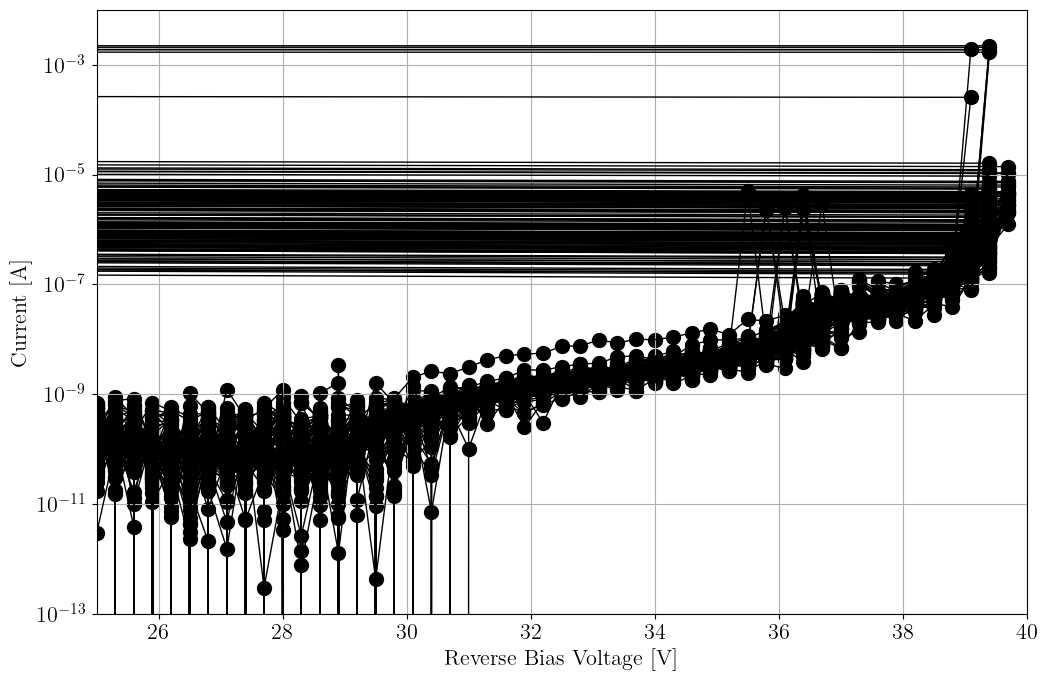

In [172]:
fig = plt.figure(figsize=(12,8))
plt.xlabel('Reverse Bias Voltage [V]')
plt.ylabel('Current [A]')
plt.yscale('log')
plt.grid()
plt.xlim(25,40)

for ii,x in enumerate(data[tags[0]]['current']):
    plt.plot(data[tags[0]]['voltage'][ii], data[tags[0]]['current'][ii], lw=1, color='k')
    plt.scatter(data[tags[0]]['voltage'][ii], data[tags[0]]['current'][ii], lw=1, color='k')
plt.show()

0 1.9595849558195129 29.5 0.5 [ 1.95958496  0.2         0.5        29.4       ]
10 2.913818626591844 29.5 0.5 [ 2.91381863  0.2         0.5        29.4       ]
20 2.1329243393791684 29.5 0.5 [ 2.13292434  0.2         0.5        29.4       ]
30 3.4094397411706474 29.5 0.5 [ 3.40943974  0.2         0.5        29.4       ]
40 2.6444273419225293 29.5 0.5 [ 2.64442734  0.2         0.5        29.4       ]
50 5.093285636297582 29.199999999999996 0.5 [ 5.09328564  0.2         0.5        29.1       ]
60 3.6869060459451273 27.1 0.5 [ 3.68690605  0.2         0.5        27.        ]
70 4.355712557582512 29.800000000000004 0.5 [ 4.35571256  0.2         0.5        29.7       ]
80 2.45876282531188 29.199999999999996 0.5 [ 2.45876283  0.2         0.5        29.1       ]
90 3.1699090790041717 29.199999999999996 0.5 [ 3.16990908  0.2         0.5        29.1       ]
100 2.266435218170206 29.199999999999996 0.5 [ 2.26643522  0.2         0.5        29.1       ]
110 3.383029435535003 29.199999999999996 0.5 

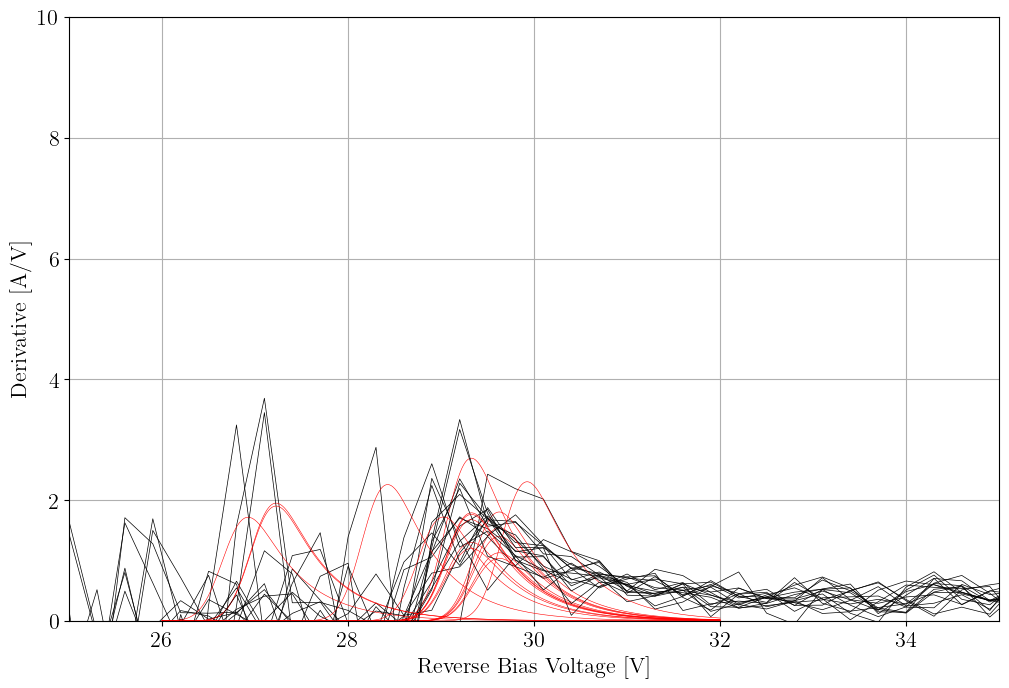

[29.4, 29.4, 29.4, 29.4, 29.4, 29.099999999999994, 27.0, 29.700000000000003, 29.099999999999994, 29.099999999999994, 29.099999999999994, 29.099999999999994, 26.700000000000003, 27.0, 28.799999999999997, 28.200000000000003, 29.099999999999998]


In [178]:
fig = plt.figure(figsize=(12,8))
plt.xlabel('Reverse Bias Voltage [V]')
plt.ylabel('Derivative [A/V]')
plt.grid()
plt.xlim(25,35)
plt.ylim(0,10)

def gauss(x,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))

def func(x,V0,sigma,tau,mu):
        return 0.5*V0 * np.exp(0.5 * (sigma/tau)**2 - (x-mu)/tau) * erfc(1/np.sqrt(2) * (sigma/tau - (x-mu)/sigma))

breakdown = []

for x in range(len(data[tags[0]]['current'])):
    avg = 10
    ii = x*avg
    if ii >= len(data[tags[0]]['current']):
        break
    # print(x,ii)
    voltage = np.mean(data[tags[0]]['voltage'][ii:ii+avg], axis=0)
    current = np.median(data[tags[0]]['current'][ii:ii+avg], axis=0)

    grad_v = np.gradient(voltage)
    grad_i =  np.gradient(np.log(np.abs(current)))
    grad_i[np.isnan(grad_i)] = 0
    
    plt.plot(voltage, grad_i/grad_v, color='k', lw=0.5)
    # plt.scatter(voltage, grad_i/grad_v, color='k', s=5)

    min_x = 26
    max_x = 32
    cut = np.where((voltage<max_x)&(voltage>min_x))[0]

    v_max = np.max(grad_i/grad_v)
    
    cut_max = np.where( (grad_i/grad_v)[cut] == np.max((grad_i/grad_v)[cut])  )

    v_mu = voltage[cut][cut_max][0]
    v_sig = 0.5
    # popt,pcov = curve_fit(func, grad_v[cut], grad_i[cut], p0=[v_max,v_mu,v_sig], bounds=([1,28,0.1],[10,32,1]), maxfev=100)
    popt,pcov = curve_fit(func, grad_v[cut], grad_i[cut], p0=[v_max,0.2,0.5,v_mu-0.1], bounds=([0,0.1,0,25],[100,5,5,32]))
    # popt,pcov = curve_fit(func, grad_v[cut], grad_i[cut], p0=[*popt], bounds=([0,0.1,0,25],[100,5,5,32]))

    print(ii,v_max, v_mu, v_sig,popt)
    xfit = np.linspace(min_x, max_x, 1000)
    plt.plot(xfit, func(xfit, *popt), color='r', lw=0.4)

    breakdown.append(popt[3])



plt.show()
print(breakdown)


In [179]:
print(np.mean(breakdown))

28.764705882352942


In [180]:
print(t_diff_sipm, breakdown)

[51805. 51823. 51841. 51860. 51878. 51897. 51916. 51935. 51955. 51974.
 51993. 52011. 52030. 52049. 52067. 52086. 52105. 52123. 52142. 52161.
 52179. 52198. 52217. 52236. 52254. 52272. 52290. 52309. 52328. 52346.
 52365. 52383. 52402. 52420. 52438. 52458. 52477. 52495. 52514. 52533.
 52552. 52570. 52589. 52608. 52626. 52645. 52664. 52682. 52701. 52720.
 52738. 52756. 52775. 52793. 52812. 52831. 52850. 52869. 52888. 52906.
 52925. 52943. 52961. 52980. 52999. 53017. 53036. 53055. 53074. 53093.
 53111. 53130. 53148. 53167. 53185. 53203. 53222. 53241. 53261. 53280.
 53298. 53317. 53336. 53354. 53373. 53391. 53411. 53430. 53448. 53467.
 53485. 53504. 53523. 53541. 53560. 53579. 53598. 53616. 53634. 53653.
 53671. 53690. 53708. 53726. 53744. 53763. 53782. 53800. 53818. 53837.
 53855. 53873. 53892. 53911. 53929. 53947. 53966. 53984. 54003. 54022.
 54041. 54059. 54078. 54096. 54115. 54134. 54153. 54171. 54190. 54208.
 54226. 54245. 54262. 54280. 54299. 54318. 54337. 54356. 54375. 54393.
 54411

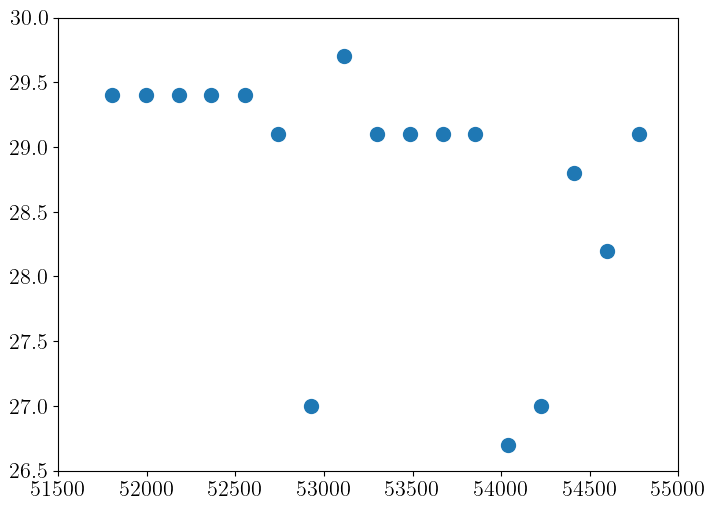

In [181]:
plt.figure()
plt.scatter(np.array(t_diff_sipm)[::avg], np.array(breakdown))
plt.show()

In [167]:
Path = 'C:/Data/SiPM/FBK-HD3/'
Date = '20211108'
tags = ['Cooldown']

t_diff_temp = [(x - dt.datetime(2021, 11, 8, 0, 0, 0)).total_seconds() for x in AllSensors.Time]
# t_diff_sipm = h5py.File('{}/{}/{}.h5'.format(Path,Date,tag), 'r').keys()

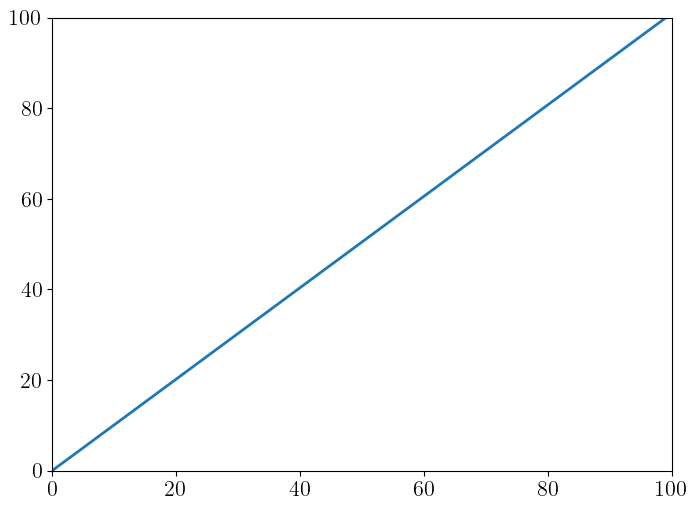

In [168]:
x = np.linspace(0,100,100)
plt.figure()
plt.plot(x, )

In [169]:
print(len(data[tags[0]]['current']))

KeyError: 'Cooldown'

0 0
1 10
2 20
3 30
4 40


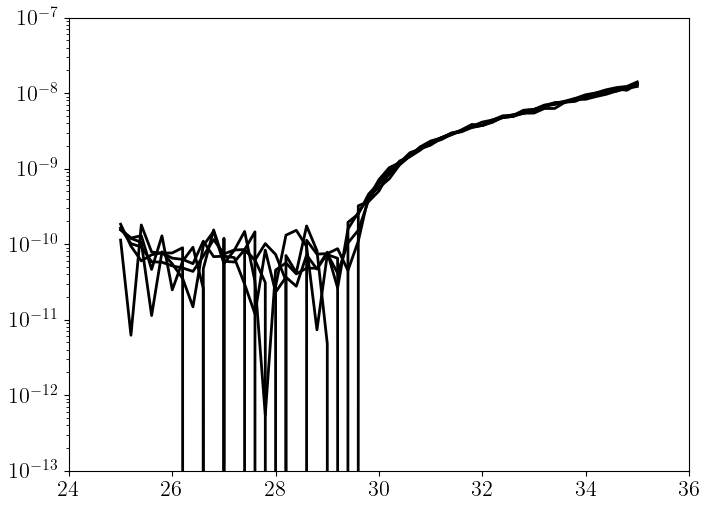

In [ ]:
plt.figure()
for x in range(len(data[tags[0]]['current'])):
    avg = 10
    ii = x*avg
    if ii >= len(data[tags[0]]['current']):
        break
    print(x,ii)
    voltage = np.mean(data[tags[0]]['voltage'][ii:ii+avg], axis=0)
    current = np.median(data[tags[0]]['current'][ii:ii+avg], axis=0)

    plt.plot(voltage,current, color='k')

plt.yscale('log')


In [370]:
D1 = Dataset.Dataset(Path='C:/Data/20211108/', Selection='*.h5')
print(len(D1.Files))
D1.Ch[1].Pol = 1
for File in D1.Files:
    D1.ImportDataFromHDF5(File, D1.Ch)

311


In [371]:
Print=True
for ii, ch in enumerate(D1.Ch):
    ch.GetSampling()
    ch.Amp = np.array(ch.Amp)
    ch.TimeStamp = np.array(sorted(ch.TimeStamp))
    ch.Amp = ch.SubtractBaseline(Data=ch.Amp, state=Print)
    ch.GetAllMaxima(Data=ch.Amp, state=Print)
    ch.GetIntegral(Data=ch.Amp, state=Print)


 | Subtracting baseline...
 | Getting extrema of individual files...
 | Getting average waveform...
 | Subtracting baseline...
 | Getting extrema of individual files...
 | Getting average waveform...


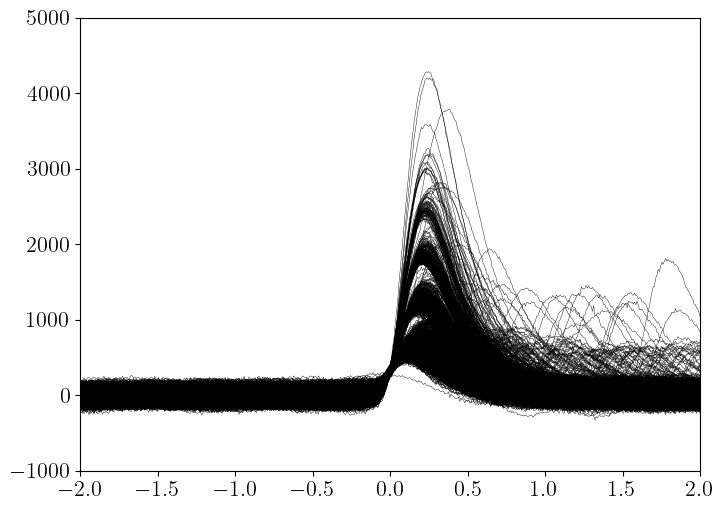

In [372]:
plt.figure()
plt.xlim(-2,2)
for x in D1.Ch[1].Amp:
    plt.plot(D1.Ch[1].Time, x, color='k', lw=0.3)
plt.show()

[230.11374992 632.69331166  95.95619711] 0.1516630496070876
[  41.8670845  1247.92078915   90.91011603] 0.07284926801432808
[  10.23106398 1841.12523866   68.19356499] 0.03703906912769252
[   2.83761156 2445.58664507   58.93993373] 0.024100529763113027
[8.50390770e-01 2.99227286e+03 2.54487687e+01] 0.008504828880542261


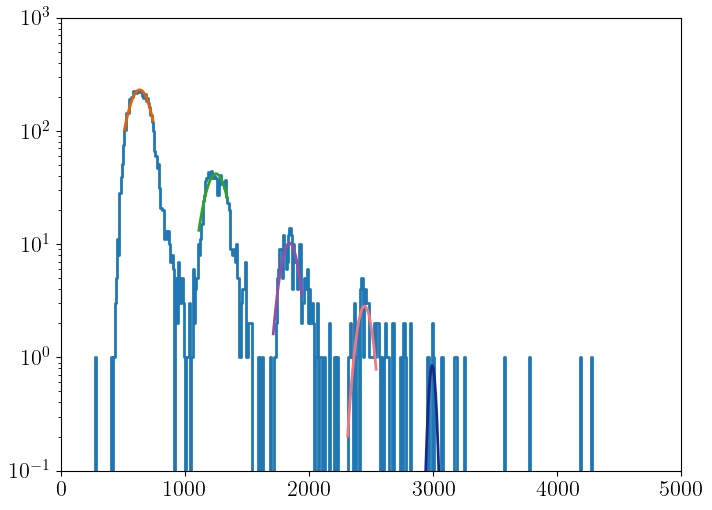

In [373]:
def gauss(x,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))


plt.figure()
plt.yscale('log')
plt.xlim(0,5000)
plt.ylim(0.1,1000)

xfit = np.arange(0,3000,10)
h,hx = np.histogram(D1.Ch[1].Max, bins=np.arange(0,5000,10))
plt.step(hx[:-1], h)

gain = []
for x in [600, 1200, 1800, 2400, 3000]:
    pe_1 = np.where((hx>x-100) & (hx<x+150))[0]
    popt1, pcov1 = curve_fit(gauss, hx[pe_1], h[pe_1], 
                            p0=[np.max(h[pe_1]), hx[pe_1][np.where(h[pe_1]==np.max(h[pe_1]) )[0]][0], 50])
    plt.plot(hx[pe_1], gauss(hx[pe_1], *popt1))
    print(popt1, popt1[2]/popt1[1])

    gain.append(popt1[1])

plt.show()

In [374]:
diff = np.mean(np.diff(gain))

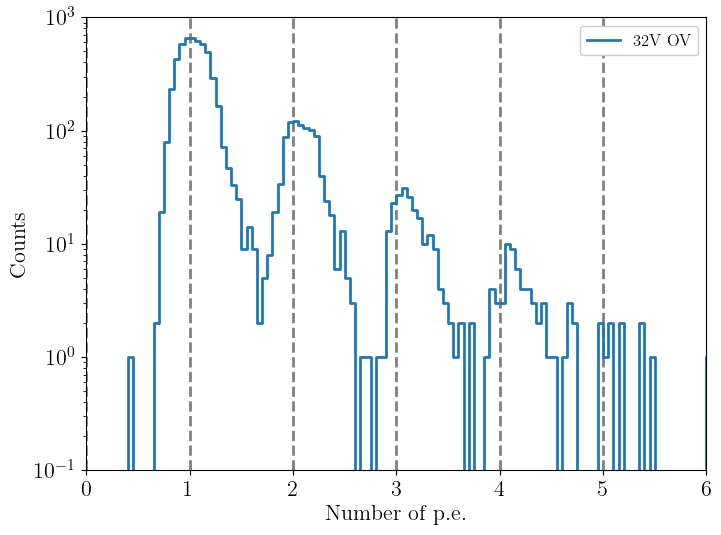

In [375]:
plt.figure()
plt.xlabel('Number of p.e.')
plt.ylabel('Counts')
plt.yscale('log')
plt.xlim(0,6)
plt.ylim(0.1,1000)

h,hx = np.histogram(D1.Ch[1].Max/diff, bins=np.arange(0,10,0.05))
plt.step(hx[:-1], h, label='32V OV')
for x in range(6):
    plt.vlines(x=x,ymin=0.1,ymax=1e5, ls='--', color='grey')

plt.legend(loc='upper right')
plt.savefig('pulse_height_spectrum.pdf')
plt.show()